In [1]:
from datetime import datetime, timedelta, timezone
from dateutil.tz import tzutc
from dateutil.relativedelta import relativedelta
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
from scipy.stats import pearsonr, mode, skew, kurtosis
from scipy.signal import savgol_filter
import xgboost as xgb
from joblib import Parallel, delayed
import sklearn
import pickle
from sklearn.metrics import mean_squared_error, plot_confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, ShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

CM_LAG_CORRECTION = [("p1", timedelta(minutes=2 * 60 + 36)), ("p2", timedelta(minutes=0)), ("p3", timedelta(minutes=2 * 60)), ("p4", timedelta(minutes=0))]


OUTTER_WINDOW_LENGTH = timedelta(minutes=30)
INNER_WINDOW_LENGTH = timedelta(seconds=60)
COMPLEX_MEAL_LENGTH = timedelta(minutes=180)
FASTING_LENGTH = timedelta(minutes=30)
MINIMUM_POINT = INNER_WINDOW_LENGTH.total_seconds()

START_OF_TRIAL = datetime.strptime("11 06 2021-04:00:00", "%m %d %Y-%H:%M:%S")  # to handle the daylight saving issue in apple watches
END_OF_TRIAL = datetime.strptime("11 15 2021-00:00:00", "%m %d %Y-%H:%M:%S")
DAY_LIGHT_SAVING = datetime.strptime("11 06 2021-02:00:00", "%m %d %Y-%H:%M:%S")
coreNumber = 1

addDataPrefix = "/Users/sorush/My Drive/Documents/Educational/TAMU/Research/Trial/Data/11-5-21-11-15-21"
if not os.path.exists(addDataPrefix):
    addDataPrefix = "/home/grads/s/sorush.omidvar/CGMDataset/Trial/Data/11-5-21-11-15-21"
if not os.path.exists(addDataPrefix):
    addDataPrefix = "C:\\GDrive\\Documents\\Educational\\TAMU\\Research\\Trial\\Data\\11-5-21-11-15-21"

addUserInput = os.path.join(addDataPrefix, "User inputted")
addHKCM = os.path.join(addDataPrefix, "hk+cm")
addCGM = os.path.join(addDataPrefix, "CGM")
addE4 = os.path.join(addDataPrefix, "E4")

exempts = ["p2"]

pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({"figure.facecolor": "white"})
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # no GPU

import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 500)


In [2]:
def timeZoneFixer(df, LocalizeFlag, columnName):
    if LocalizeFlag:
        df[columnName] -= timedelta(hours=5)
    tempColumn = df[columnName]
    tempColumn[tempColumn >= DAY_LIGHT_SAVING] -= timedelta(hours=1)
    df[columnName] = tempColumn

    df = df[df[columnName] <= END_OF_TRIAL]
    df = df[df[columnName] >= START_OF_TRIAL]
    return df


def mealMarker(df):
    df.insert(len(df.columns), "BigMeal", False)

    for counter in range(1, len(df) - 1):
        if df["Calories"].iloc[counter] > 300:
            df["BigMeal"].iloc[counter] = True

    df.insert(len(df.columns), "ComplexMeal", False)
    participants = df["Participant"].to_list()
    participants = list(set(participants))
    for participant in participants:
        dfTemp = df[df["Participant"] == participant]
        for counter in range(1, len(dfTemp)):
            bothComplexFlag = dfTemp["BigMeal"].iloc[counter - 1] and dfTemp["BigMeal"].iloc[counter]
            if dfTemp["StartTime"].iloc[counter - 1] + OUTTER_WINDOW_LENGTH >= dfTemp["StartTime"].iloc[counter] and bothComplexFlag:
                dfTemp["ComplexMeal"].iloc[counter] = True
                dfTemp["ComplexMeal"].iloc[counter - 1] = True
        indexs = dfTemp.index[dfTemp["ComplexMeal"] == True]
        df["ComplexMeal"][indexs] = True
    return df


def mealCorrector(dfMeal):
    mealIndex = dfMeal[(dfMeal["FinishTime"] == "2021-11-07 21:57:00") & (dfMeal["MealName"] == "Pizza") & (dfMeal["Participant"] == "p1")].index
    assert len(mealIndex) == 1
    dfMeal["FinishTime"][mealIndex] = "2021-11-06 21:57:00"

    mealIndex = dfMeal[(dfMeal["FinishTime"] == "2021-11-11 22:50:00") & (dfMeal["MealName"] == "Burger") & (dfMeal["Participant"] == "p3")].index
    assert len(mealIndex) == 1
    dfMeal["FinishTime"][mealIndex] = "2021-11-10 22:50:00"

    mealIndex = dfMeal[(dfMeal["FinishTime"] == "2021-11-11 23:09:00") & (dfMeal["MealName"] == "Egg tomatoes soup") & (dfMeal["Participant"] == "p4")].index
    assert len(mealIndex) == 1
    dfMeal["FinishTime"][mealIndex] = "2021-11-10 23:09:00"

    dfMeal["MealDuration"] = dfMeal["FinishTime"] - dfMeal["StartTime"]
    dfMeal["MealDuration"] = dfMeal["MealDuration"].dt.total_seconds()
    return dfMeal


if os.path.exists(os.path.join(addDataPrefix, "Results", "All_meals.pkl")):
    os.remove(os.path.join(addDataPrefix, "Results", "All_meals.pkl"))
os.chdir(addUserInput)
if not os.path.exists(os.path.join(addDataPrefix, "Results", "All_meals.pkl")):
    dfMeal = []
    for root, dirs, files in os.walk(addUserInput):
        for file in files:
            if ".csv" in file.lower():
                if "meals" in file.lower() and "modified" not in file.lower():
                    participantName = file[: file.find("Meals")]
                    if participantName in exempts:
                        print("Exemption...", file)
                        continue
                    print("Reading ...", file)
                    dfTemp = pd.read_csv(file)
                    dfTemp.insert(0, "Participant", participantName)
                    dfTemp.rename(columns={"startTime": "StartTime"}, inplace=True)
                    dfTemp["StartTime"] = pd.to_datetime(dfTemp["StartTime"])
                    dfTemp["FinishTime"] = pd.to_datetime(dfTemp["FinishTime"])
                    dfTemp.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
                    dfTemp.reset_index(drop=True, inplace=True)

                    if len(dfMeal) != 0:
                        frames = [dfTemp, dfMeal]
                        dfMeal = pd.concat(frames)
                    else:
                        dfMeal = dfTemp
    print("reading is done")

    dfMeal = timeZoneFixer(dfMeal, True, "StartTime")
    dfMeal = timeZoneFixer(dfMeal, True, "FinishTime")
    dfMeal.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
    dfMeal.reset_index(drop=True, inplace=True)
    dfMeal.insert(4, "MealDuration", -1)
    dfMeal["MealDuration"] = dfMeal["FinishTime"] - dfMeal["StartTime"]
    dfMeal["MealDuration"] = dfMeal["MealDuration"].dt.total_seconds()
    print("Meal database is limited to the trial period")
    dfMeal.to_pickle(os.path.join(addDataPrefix, "Results", "All_meals.pkl"))
    dfMeal = mealCorrector(dfMeal)
else:
    dfMeal = pd.read_pickle(os.path.join(addDataPrefix, "Results", "All_meals.pkl"))
dfMeal = mealMarker(dfMeal)


Exemption... p2Meals.csv
Reading ... p4Meals.csv
Reading ... p3Meals.csv
Reading ... p1Meals.csv
reading is done
Meal database is limited to the trial period


In [3]:
def pdInterpolation(dfTemp):
    index = dfTemp["Time"]
    seriesParticipant = pd.Series(dfTemp["Abbot"].to_list(), index=index)
    seriesParticipant = seriesParticipant.resample("1T").asfreq()
    seriesParticipant.interpolate(method="polynomial", order=3, inplace=True)
    tempTime = seriesParticipant.index
    tempVal = seriesParticipant.values
    dfTemp = pd.DataFrame(zip(tempTime, tempVal), columns=["Time", "Abbot"])
    return dfTemp


def cmLagCorrector(df):
    participants = df["Participant"].to_list()
    participants = list(set(participants))
    dfTotal = []

    for element in CM_LAG_CORRECTION:
        participant = element[0]
        timeLag = element[1]
        dfParticipant = df[df["Participant"] == participant]
        dfParticipant["Time"] += timeLag
        if len(dfTotal) == 0:
            dfTotal = dfParticipant
        else:
            frames = [dfTotal, dfParticipant]
            dfTotal = pd.concat(frames)

    return dfTotal


def cmSmoother(df):
    columnLabels = df.columns
    for columnLabel in columnLabels:
        if columnLabel == "Time":
            continue
        tempSerie = df[columnLabel]
        tempSerie = tempSerie.ewm(span=10).mean()  # Considering the frequency of 10 Hz
        df[columnLabel] = tempSerie
    return df


# if os.path.exists(os.path.join(addDataPrefix, "Results", "All_cgm.pkl")):
#     os.remove(os.path.join(addDataPrefix, "Results", "All_cgm.pkl"))
if not os.path.exists(os.path.join(addDataPrefix, "Results", "All_cgm.pkl")):
    os.chdir(addCGM)
    dfCGM = []
    for root, dirs, files in os.walk(addCGM):
        for file in files:
            if ".txt" in file.lower():
                if "_fl" in file.lower():
                    participantName = file[: file.find("_fl")]
                    if participantName in exempts:
                        print("Exemption...", file)
                        continue
                    print("Reading ...", file)
                    dfTemp = pd.read_csv(file, sep="\t", skiprows=1)
                    if len(dfTemp.columns) != 4:
                        print("MAYDAY. Error in reading csv")
                        break
                    dfTemp.columns.values[0] = "ID"
                    dfTemp.columns.values[1] = "Time"
                    dfTemp.columns.values[2] = "Record"
                    dfTemp.columns.values[3] = "Abbot"
                    dfTemp.drop(columns=["ID", "Record"], inplace=True)
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"])
                    dfTemp["Abbot"] = pd.to_numeric(dfTemp["Abbot"])
                    dfTemp.sort_values(["Time"], ascending=(True), inplace=True)
                    dfTemp = pdInterpolation(dfTemp)
                    dfTemp.insert(0, "Participant", participantName)
                    if len(dfTemp.columns) != 3:
                        print("MAYDAY. Error in processing csv")
                        break
                    if len(dfCGM) != 0:
                        frames = [dfTemp, dfCGM]
                        dfCGM = pd.concat(frames)
                    else:
                        dfCGM = dfTemp
    print("reading is done")
    dfCGM = timeZoneFixer(dfCGM, False, "Time")
    dfCGM.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
    dfCGM.reset_index(drop=True, inplace=True)

    print("CGM database is limited to the trial period")
    dfCGM.to_pickle(os.path.join(addDataPrefix, "Results", "All_cgm.pkl"))
else:
    dfCGM = pd.read_pickle(os.path.join(addDataPrefix, "Results", "All_cgm.pkl"))


# if os.path.exists(os.path.join(addDataPrefix, "Results", "All_cm.pkl")):
#     os.remove(os.path.join(addDataPrefix, "Results", "All_cm.pkl"))
os.chdir(addHKCM)
if not os.path.exists(os.path.join(addDataPrefix, "Results", "All_cm.pkl")):
    dfCM = []
    for root, dirs, files in os.walk(addHKCM):
        for file in files:
            if ".csv" in file.lower():
                if "cm_all" in file.lower() and "modified" not in file.lower():
                    participantName = file[: file.find("_cm")]
                    if participantName in exempts:
                        print("Exemption...", file)
                        continue
                    print("Reading ...", file)
                    dfTemp = pd.read_csv(file)
                    print("File is read")
                    dfTemp["UnixTime"] = pd.to_datetime(dfTemp["UnixTime"], unit="s")

                    dfTemp.rename(columns={"UnixTime": "Time"}, inplace=True)
                    dfTemp.drop(columns=["UID", "Date"], inplace=True)
                    dfTemp.sort_values(["Time"], ascending=(True), inplace=True)

                    dfTemp = cmSmoother(dfTemp)
                    dfTemp["Yaw"] *= 180 / 3.1415
                    dfTemp["Pitch"] *= 180 / 3.1415
                    dfTemp["Roll"] *= 180 / 3.1415

                    dfTemp.insert(0, "Participant", participantName)
                    dfTemp.insert(len(dfTemp.columns), "|Ax|+|Ay|+|Az|", dfTemp["Ax"].abs() + dfTemp["Ay"].abs() + dfTemp["Az"].abs() + 0.001)  # this is to avoid 0 later on for feature calculation
                    dfTemp.insert(len(dfTemp.columns), "|Yaw|+|Roll|+|Pitch|", dfTemp["Yaw"].abs() + dfTemp["Roll"].abs() + dfTemp["Pitch"].abs())
                    dfTemp.insert(len(dfTemp.columns), "|Rx|+|Ry|+|Rz|To|Ax|+|Ay|+|Az|", dfTemp["Rx"].abs() + dfTemp["Ry"].abs() + dfTemp["Rz"].abs())
                    dfTemp["|Rx|+|Ry|+|Rz|To|Ax|+|Ay|+|Az|"] = dfTemp["|Rx|+|Ry|+|Rz|To|Ax|+|Ay|+|Az|"] / dfTemp["|Ax|+|Ay|+|Az|"]
                    dfTemp.insert(len(dfTemp.columns), "RotationalToLinear", dfTemp["|Yaw|+|Roll|+|Pitch|"] / dfTemp["|Ax|+|Ay|+|Az|"])
                    print("modified")

                    if len(dfTemp.columns) != 15:
                        print("MAYDAY. Error in reading csv")
                        print(dfTemp.columns)
                        break
                    if len(dfCM) != 0:
                        frames = [dfTemp, dfCM]
                        dfCM = pd.concat(frames)
                    else:
                        dfCM = dfTemp
    print("Processing is done")

    dfCM = cmLagCorrector(dfCM)
    # dfCM = timeZoneFixer(dfCM, False, "Time")
    dfCM.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
    dfCM.reset_index(drop=True, inplace=True)

    print("CM database is limited to the trial period")
    dfCM.to_pickle(os.path.join(addDataPrefix, "Results", "All_cm.pkl"))
else:
    dfCM = pd.read_pickle(os.path.join(addDataPrefix, "Results", "All_cm.pkl"))


# if os.path.exists(os.path.join(addDataPrefix, "Results", "All_E4.pkl")):
#     os.remove(os.path.join(addDataPrefix, "Results", "All_E4.pkl"))
os.chdir(addE4)
# fields=['ACC','BVP','EDA','HR','IBI','TEMP']
fields = ["HR"]
if not os.path.exists(os.path.join(addDataPrefix, "Results", "All_E4.pkl")):
    dfE4 = []
    for root, dirs, files in os.walk(addE4):
        for file in files:
            if ".csv" in file.lower():
                participantName = root[root.find("E4") + 3 :]
                participantName = participantName[:2]
                field = file[: file.find(".csv")]
                if field not in fields:
                    print("File name does not comply with analyzed fields", file)
                    continue
                print(participantName, field)
                if participantName in exempts:
                    print("Exemption...", file)
                    continue
                print("Reading ...", file)
                os.chdir(root)
                dfTemp = pd.read_csv(file, header=None)
                # if field=='ACC':
                #     assert len(dfTemp.columns)==3
                #     timeBase=dfTemp.iloc[0,0]
                #     timeStep=1/dfTemp.iloc[1,0]
                #     dfTemp.drop([0,1],inplace=True)
                #     dfTemp.rename(columns={0:'Data1',1:'Data2',2:'Data3'}, inplace=True)#x,y,z for data1,data2,data3
                #     timeTemp=[]
                #     for counter in range(len(dfTemp)):
                #         timeTemp.append(timeBase+counter*timeStep)
                #     dfTemp.insert(0,'Time',timeTemp)
                #     dfTemp.insert(0,'Field',"Acceleration")
                #     dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')
                # if field == "BVP":
                #     assert len(dfTemp.columns) == 1
                #     timeBase = dfTemp.iloc[0, 0]
                #     timeStep = 1 / dfTemp.iloc[1, 0]
                #     dfTemp.drop([0, 1], inplace=True)
                #     dfTemp.rename(columns={0: "Data1"}, inplace=True)
                #     dfTemp["Data2"] = ""
                #     dfTemp["Data3"] = ""
                #     timeTemp = []
                #     for counter in range(len(dfTemp)):
                #         timeTemp.append(timeBase + counter * timeStep)
                #     dfTemp.insert(0, "Time", timeTemp)
                #     dfTemp.insert(0, "Field", "BVP")
                #     dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                if field == "HR":
                    assert len(dfTemp.columns) == 1
                    timeBase = dfTemp.iloc[0, 0]
                    timeStep = 1 / dfTemp.iloc[1, 0]
                    dfTemp.drop([0, 1], inplace=True)
                    dfTemp.rename(columns={0: "Data1"}, inplace=True)
                    dfTemp["Data2"] = ""
                    dfTemp["Data3"] = ""
                    timeTemp = []
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase + counter * timeStep)
                    dfTemp.insert(0, "Time", timeTemp)
                    dfTemp.insert(0, "Field", "HR")
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                # elif field == "EDA":
                #     assert len(dfTemp.columns) == 1
                #     timeBase = dfTemp.iloc[0, 0]
                #     timeStep = 1 / dfTemp.iloc[1, 0]
                #     dfTemp.drop([0, 1], inplace=True)
                #     dfTemp.rename(columns={0: "Data1"}, inplace=True)
                #     dfTemp["Data2"] = ""
                #     dfTemp["Data3"] = ""
                #     timeTemp = []
                #     for counter in range(len(dfTemp)):
                #         timeTemp.append(timeBase + counter * timeStep)
                #     dfTemp.insert(0, "Time", timeTemp)
                #     dfTemp.insert(0, "Field", "EDA")
                #     dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                # elif field=='IBI':
                #     assert len(dfTemp.columns)==2
                #     timeBase=dfTemp.iloc[0,0]
                #     dfTemp.drop([0],inplace=True)
                #     dfTemp.rename(columns={0:'Time',1:'Data1'}, inplace=True)
                #     dfTemp["Data2"]=""
                #     dfTemp["Data3"]=""
                #     timeTemp=[]
                #     dfTemp['Time']+=timeBase
                #     dfTemp.insert(0,'Field',"IBI")
                #     dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')
                # elif field == "TEMP":
                #     assert len(dfTemp.columns) == 1
                #     timeBase = dfTemp.iloc[0, 0]
                #     timeStep = 1 / dfTemp.iloc[1, 0]
                #     dfTemp.drop([0, 1], inplace=True)
                #     dfTemp.rename(columns={0: "Data1"}, inplace=True)
                #     dfTemp["Data2"] = ""
                #     dfTemp["Data3"] = ""
                #     timeTemp = []
                #     for counter in range(len(dfTemp)):
                #         timeTemp.append(timeBase + counter * timeStep)
                #     dfTemp.insert(0, "Time", timeTemp)
                #     dfTemp.insert(0, "Field", "Temperature")
                #     dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                dfTemp.insert(0, "Participant", participantName)
                dfTemp.sort_values(["Participant", "Field", "Time"], ascending=(True, True, True), inplace=True)
                if len(dfTemp.columns) != 6:
                    print("MAYDAY. Error in reading csv")
                    break
                if len(dfE4) != 0:
                    frames = [dfTemp, dfE4]
                    dfE4 = pd.concat(frames)
                else:
                    dfE4 = dfTemp

    print("reading is done")
    dfE4 = timeZoneFixer(dfE4, True, "Time")
    dfE4.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
    dfE4.reset_index(drop=True, inplace=True)
    print("E4 database is limited to the trial period")
    dfE4.to_pickle(os.path.join(addDataPrefix, "Results", "All_E4.pkl"))
else:
    dfE4 = pd.read_pickle(os.path.join(addDataPrefix, "Results", "All_E4.pkl"))


In [ ]:
# T1 = datetime.strptime("11 07 2021-00:00:00", "%m %d %Y-%H:%M:%S")  # to handle the daylight saving issue in apple watches
# T2 = T1 + timedelta(hours=2 * 24)

# myParticipant='p1'

# dfTemp = dfCM[dfCM["Participant"] == myParticipant]
# for counter in range(1):
#     T1 += timedelta(hours=24)
#     T2 += timedelta(hours=24)
#     plt.figure(figsize=(25, 10))

#     dfTemp = dfTemp[dfTemp["Time"] >= T1]
#     dfTemp = dfTemp[dfTemp["Time"] < T2]

#     x = dfTemp["Time"].to_list()
#     y = dfTemp["Yaw"].to_list()

#     plt.scatter(x, y, color="k")

#     dfTemp = dfE4[dfE4["Participant"] == myParticipant]
#     dfTemp = dfTemp[dfTemp["Time"] >= T1]
#     dfTemp = dfTemp[dfTemp["Time"] < T2]
#     dfTemp = dfTemp[dfTemp["Field"] == "HR"]
#     dfTemp = dfTemp[["Time", "Field", "Data1"]]

#     x = dfTemp["Time"].to_list()
#     y = dfTemp["Data1"].to_list()
#     y = np.asarray(y)
#     y /= np.max(y)
#     y += 1

#     plt.scatter(x, y)

#     dfTemp=dfMeal[dfMeal['Participant']==myParticipant]
#     dfTemp=dfTemp[dfTemp['StartTime']>=T1]
#     dfTemp=dfTemp[dfTemp['StartTime']<T2]
#     dfTemp=dfTemp['StartTime'].to_list()
#     plt.scatter(x,np.zeros(len(x),),color='red')
#     plt.grid(which='both',color='r', linestyle='-', linewidth=0.5)
#     plt.minorticks_on()
#     plt.show()



In [17]:
def e4Reporter(df):
    topics = ["BVP", "EDA", "HR", "Temperature"]
    report = []
    for topic in topics:
        dfTemp = df[df["Field"] == topic]
        if topic == "BVP":
            MIN_POINT = MINIMUM_POINT * 64 * 0.3
        elif topic == "EDA":
            MIN_POINT = MINIMUM_POINT * 4 * 0.3
        elif topic == "HR":
            MIN_POINT = MINIMUM_POINT / 10 * 0.3
        elif topic == "Temperature":
            MIN_POINT = MINIMUM_POINT * 4 * 0.3
        else:
            print("MAYDAY at sensor reader")
            os._exit()
        if len(dfTemp) < MIN_POINT:
            report.append("Nan")
        else:
            val = dfTemp["Data1"].mean()
            report.append(val)
    return report


def motionCalculator(df):
    f1 = df["RotationalToLinear"]
    f2 = df["|Ax|+|Ay|+|Az|"]
    return [f1.mean(), f1.std(), f1.max() - f1.min(), f2.mean(), f2.std(), f2.max() - f2.min()]


def statFeatures(dataList):
    dataList = np.asarray(dataList).astype(float)
    result = []
    dataDim = dataList.ndim
    if dataDim > 1:
        for counter in range(dataList.shape[1]):
            if not np.isnan(dataList[:, counter]).all():
                meanVal = np.nanmean(dataList[:, counter], axis=0)
                stdVal = np.nanstd(dataList[:, counter], axis=0)
                minVal = np.nanmin(dataList[:, counter], axis=0)
                maxVal = np.nanmax(dataList[:, counter], axis=0)
                rangeVal = maxVal - minVal
                skewnessVal = skew(dataList[:, counter], nan_policy="omit", axis=0)
                kurtosisVal = kurtosis(dataList[:, counter], nan_policy="omit", axis=0)
                result.extend([rangeVal, meanVal, stdVal, minVal, maxVal, skewnessVal, kurtosisVal])
            else:
                result.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
    else:
        if not np.isnan(dataList).all():
            meanVal = np.nanmean(dataList)
            stdVal = np.nanstd(dataList)
            minVal = np.nanmin(dataList)
            maxVal = np.nanmax(dataList)
            rangeVal = maxVal - minVal
            skewnessVal = skew(dataList, nan_policy="omit")
            kurtosisVal = kurtosis(dataList, nan_policy="omit")
            result.extend([rangeVal, meanVal, stdVal, minVal, maxVal, skewnessVal, kurtosisVal])
        else:
            result.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
    return result


def innerWindowExtractor(outterWindowStart, innerWindowNumber, dfParticipantCM, dfParticipantE4):
    tempListCM = []
    tempListE4 = []
    for counterInner in range(0, innerWindowNumber, 1):
        innerWindowStart = outterWindowStart + counterInner * INNER_WINDOW_LENGTH
        innerWindowEnd = innerWindowStart + INNER_WINDOW_LENGTH
        dfTempCM = dfParticipantCM[(dfParticipantCM["Time"] >= innerWindowStart) & (dfParticipantCM["Time"] < innerWindowEnd)]

        if len(dfTempCM) < MINIMUM_POINT * 10 * 0.3:
            tempListCM.append(["Nan", "Nan", "Nan", "Nan", "Nan", "Nan"])
        else:
            tempListCM.append(motionCalculator(dfTempCM))

        tempListE4.append(["Nan", "Nan", "Nan", "Nan", "Nan", "Nan"])
        # dfTempE4 = dfParticipantE4[(dfParticipantE4["Time"] >= innerWindowStart) & (dfParticipantE4["Time"] < innerWindowEnd)]
        # if len(dfTempE4) < MINIMUM_POINT * 32 * 0.3:
        #     tempListE4.append(["Nan", "Nan", "Nan", "Nan","Nan","Nan"])
        # else:
        #     tempListE4.append(e4Reporter(dfTempE4))

    return tempListCM, tempListE4


def parallelCall(windowData, dfParticipantCM, dfParticipantE4, dfParticipantCGM):
    tempList = []
    outterWindowStart = windowData[0]
    outterWindowEnd = windowData[1]
    innerWindowNumber = windowData[2]
    carbs = windowData[3]
    fat = windowData[4]
    protein = windowData[5]
    mealFlag = windowData[6]
    participant = windowData[7]

    dfTempCM = dfParticipantCM[(dfParticipantCM["Time"] >= outterWindowStart) & (dfParticipantCM["Time"] < outterWindowEnd)]
    dfTempE4 = dfParticipantE4[(dfParticipantE4["Time"] >= outterWindowStart) & (dfParticipantE4["Time"] < outterWindowEnd)]
    tempListCM, tempListE4 = innerWindowExtractor(outterWindowStart, innerWindowNumber, dfTempCM, dfTempE4)

    # tempListCM = statFeatures(tempListCM)
    tempList.append(tempListCM)  # 1

    # tempListE4 = statFeatures(tempListE4)
    tempList.append(tempListE4)  # 1

    dfTempCGM = dfParticipantCGM[(dfParticipantCGM["Time"] >= outterWindowStart) & (dfParticipantCGM["Time"] < outterWindowEnd)]
    tempListCGM = dfTempCGM["Abbot"].to_list()
    tempListCGM = statFeatures(tempListCGM)
    tempList.extend(tempListCGM)  # 7

    tempList.append(outterWindowStart)  # 1
    tempList.append(outterWindowEnd)  # 1
    tempList.append(participant)  # 1

    tempList.append(carbs)  # 1
    tempList.append(fat)  # 1
    tempList.append(protein)  # 1

    tempList.append(mealFlag)  # mealFlag

    assert len(tempList) == 1 + 1 + 7 + 3 + 3 + 1

    return tempList


def outterNegWindowExtractor(dfParticipantMeal, dfParticipantCM, dfParticipantE4, dfParticipantCGM, participant):
    print("Negative windows:")
    participantDataList = []
    gaps = []
    for counterOuter in range(1, len(dfParticipantMeal)):
        # if dfParticipantMeal["StartTime"].iloc[counterOuter] - dfParticipantMeal["StartTime"].iloc[counterOuter - 1] >= FASTING_LENGTH:
        if not dfParticipantMeal["ComplexMeal"].iloc[counterOuter]:
            counter = 0
            while True:
                endQuerry = dfParticipantMeal["StartTime"].iloc[counterOuter] - counter * OUTTER_WINDOW_LENGTH
                startQuerry = endQuerry - OUTTER_WINDOW_LENGTH
                if startQuerry > dfParticipantMeal["StartTime"].iloc[counterOuter - 1] + FASTING_LENGTH:
                    gaps.append([startQuerry, endQuerry])
                else:
                    break
                if counter == 3:  # Each positive window can have 3 negative winodws at most
                    break
                counter += 1
    windowDatas = []
    for counterOuter in range(len(gaps)):
        element = gaps[counterOuter]
        outterWindowStart = element[0]
        outterWindowEnd = element[1]
        innerWindowNumber = int(OUTTER_WINDOW_LENGTH.total_seconds() / INNER_WINDOW_LENGTH.total_seconds())

        carbs = 0
        fat = 0
        protein = 0

        windowDatas.append([outterWindowStart, outterWindowEnd, innerWindowNumber, carbs, fat, protein, 0, participant])
    for counterOuter in tqdm(range(len(windowDatas))):
        windowData = windowDatas[counterOuter]
        participantDataList.append(parallelCall(windowData, dfParticipantCM, dfParticipantE4, dfParticipantCGM))
    # participantDataList = Parallel(n_jobs=coreNumber)(delayed(parallelCall)(windowData, dfParticipantCM, dfParticipantE4, dfParticipantCGM) for windowData in tqdm(windowDatas))
    return participantDataList


def outterPosWindowExtractor(dfParticipantMeal, dfParticipantCM, dfParticipantE4, dfParticipantCGM, participant):
    print("Positive windows:")
    windowDatas = []
    participantDataList = []
    for counterOuter in range(len(dfParticipantMeal)):
        if not dfParticipantMeal["BigMeal"].iloc[counterOuter] or dfParticipantMeal["ComplexMeal"].iloc[counterOuter]:
            continue
        outterWindowStart = dfParticipantMeal["StartTime"].iloc[counterOuter]
        outterWindowEnd = outterWindowStart + OUTTER_WINDOW_LENGTH
        innerWindowNumber = int(OUTTER_WINDOW_LENGTH.total_seconds() / INNER_WINDOW_LENGTH.total_seconds())

        carbs = dfParticipantMeal["Carbs"].iloc[counterOuter]
        fat = dfParticipantMeal["Fat"].iloc[counterOuter]
        protein = dfParticipantMeal["Protein"].iloc[counterOuter]

        windowDatas.append([outterWindowStart, outterWindowEnd, innerWindowNumber, carbs, fat, protein, 1, participant])
    for counterOuter in tqdm(range(len(windowDatas))):
        windowData = windowDatas[counterOuter]
        participantDataList.append(parallelCall(windowData, dfParticipantCM, dfParticipantE4, dfParticipantCGM))
    # participantDataList = Parallel(n_jobs=coreNumber)(delayed(parallelCall)(windowData, dfParticipantCM, dfParticipantE4, dfParticipantCGM) for windowData in tqdm(windowDatas))
    return participantDataList


def main():
    allDataList = []
    participants = dfMeal["Participant"].to_list()
    participants = list(set(participants))
    for participant in participants:
        print("Participant:", participant)
        if participant in exempts:
            continue
        dfParticipantMeal = dfMeal[dfMeal["Participant"] == participant]
        dfParticipantCM = dfCM[dfCM["Participant"] == participant]
        dfParticipantE4 = dfE4[dfE4["Participant"] == participant]
        dfParticipantCGM = dfCGM[dfCGM["Participant"] == participant]
        participantDataList = outterPosWindowExtractor(dfParticipantMeal, dfParticipantCM, dfParticipantE4, dfParticipantCGM, participant)
        participantDataList.extend(outterNegWindowExtractor(dfParticipantMeal, dfParticipantCM, dfParticipantE4, dfParticipantCGM, participant))
        participantDataList = pd.DataFrame(participantDataList, columns=["CM", "E4", "CGM-Mean", "CGM-Std", "CGM-Min", "CGM-Max", "CGM-Range", "CGM-Skewness", "CGM-kurtosis", "StartTime", "FinishTime", "Participant", "Carb", "Fat", "Protein", "MealLabel"])
        if len(allDataList) == 0:
            allDataList = participantDataList
        else:
            frames = [allDataList, participantDataList]
            allDataList = pd.concat(frames)
    
    allDataList.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
    allDataList.reset_index(drop=True, inplace=True)
    allDataList.to_pickle(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl")))
    return allDataList


# if os.path.exists(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl"))):
#     os.remove(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl")))
if not os.path.exists(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl"))):
    dfAllFeatures = main()

else:
    dfAllFeatures = pd.read_pickle(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl")))


100%|██████████| 154/154 [00:10<00:00, 15.13it/s]


Total: 154 Positive windows: 18
0.7475490196078431


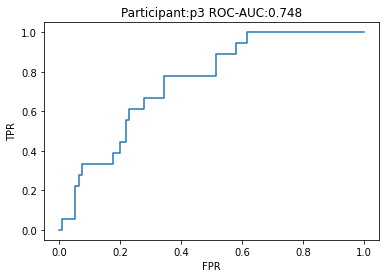

100%|██████████| 112/112 [00:07<00:00, 14.63it/s]


Total: 112 Positive windows: 18
0.5632387706855793


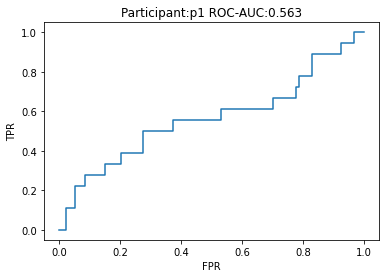

100%|██████████| 80/80 [00:05<00:00, 14.52it/s]


Total: 80 Positive windows: 9
0.3184663536776212


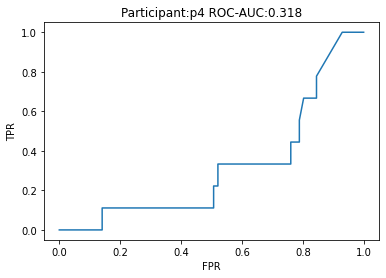

In [18]:
def meanSTDFinder(df):
    cmData = []
    for counter in range(len(df)):
        elements = df["CM"].iloc[counter]
        for element in elements:
            cmData.append(element)
    cmData = np.asarray(cmData).astype(float)
    cmDataMean = np.nanmean(cmData, axis=0)
    cmDataStd = np.nanstd(cmData, axis=0)
    return cmDataMean, cmDataStd


def cmNormalizerPredictor(element, cmDataMean, cmDataStd, hooverModel):
    element = np.asarray(element).astype(float)
    element -= cmDataMean
    element /= cmDataStd
    element = np.expand_dims(element, axis=0)
    hooverPrediction = hooverModel.predict_proba(element)
    hooverPrediction = hooverPrediction[0, 1]

    return hooverPrediction


def maxProbWinodFinder(tempPredictions):
    tempMax = -1
    for innerCounter in range(len(tempPredictions) - 5):
        tempArray = np.asarray(tempPredictions[innerCounter : innerCounter + 5])
        tempArray = np.mean(tempArray)
        if tempArray > tempMax:
            tempMax = tempArray
    return tempMax


def hooverPredictor(dfAllFeatures):
    hooverModelAdd = "/home/grads/s/sorush.omidvar/CGMDataset/Hoover/HooverModel-0.8.sav"
    hooverModel = pickle.load(open(hooverModelAdd, "rb"))
    participants = dfAllFeatures["Participant"].to_list()
    participants = list(set(participants))
    dfTotal = []
    for participant in participants:
        dfTemp = dfAllFeatures[dfAllFeatures["Participant"] == participant]
        cmDataMean, cmDataStd = meanSTDFinder(dfTemp)

        predictions = []
        groundTruth = []
        for counter in tqdm(range(len(dfTemp))):
            elements = dfTemp["CM"].iloc[counter]
            tempPredictions = []
            for element in elements:
                tempPredictions.append(cmNormalizerPredictor(element, cmDataMean, cmDataStd, hooverModel))
            # predictions.append(maxProbWinodFinder(tempPredictions))
            dfTemp["CM"].iloc[counter] = maxProbWinodFinder(tempPredictions)
            # groundTruth.append(dfTemp["MealLabel"].iloc[counter])
        if len(dfTotal) != 0:
            frames = [dfTotal, dfTemp]
            dfTotal = pd.concat(frames)
        else:
            dfTotal = dfTemp
        predictions = dfTemp["CM"].to_list()
        groundTruth = dfTemp["MealLabel"].to_list()
        print("Total:", len(groundTruth), "Positive windows:", np.sum(groundTruth))
        fpr, tpr, thresholds = roc_curve(groundTruth, predictions, pos_label=1)
        print(roc_auc_score(groundTruth, predictions))
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title("Participant:" + participant+" ROC-AUC:"+str(np.round(roc_auc_score(groundTruth, predictions),3)))
        plt.plot(fpr, tpr)
        plt.plot([0, 0], [1, 1], color="red")
        plt.show()
    return dfTotal

dfAllFeatures = pd.read_pickle(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl")))
dfAllFeatures = hooverPredictor(dfAllFeatures)



In [24]:
# def rmseCalculator(trueGround, prediction):
#     rmse = 0
#     assert len(trueGround) == len(prediction)
#     for counter in range(len(trueGround)):
#         tempVal = trueGround[counter] - prediction[counter]
#         tempVal *= tempVal
#         rmse += tempVal
#     rmse /= len(trueGround)
#     rmse = np.sqrt(rmse)
#     return rmse


# def rmsleCalculator(trueGround, prediction):
#     rmsle = 0
#     assert len(trueGround) == len(prediction)
#     for counter in range(len(trueGround)):
#         tempVal = np.log(1 + prediction[counter]) - np.log(1 + trueGround[counter])
#         tempVal *= tempVal
#         rmsle += tempVal
#     rmsle /= len(trueGround)
#     rmsle = np.sqrt(rmsle)
#     return rmsle


# def randomForester(xTrain, xTest, yTrain, yTest):
#     clf = RandomForestClassifier(n_estimators=100, max_depth=3)
#     clf.fit(xTrain, yTrain)
#     predictionsTest = clf.predict(xTest)

#     confMatrix = sklearn.metrics.confusion_matrix(yTest, predictionsTest)
#     accuracy = sklearn.metrics.accuracy_score(yTest, predictionsTest)
#     recall = sklearn.metrics.recall_score(yTest, predictionsTest)
#     precision = sklearn.metrics.precision_score(yTest, predictionsTest)
#     f1Score = sklearn.metrics.f1_score(yTest, predictionsTest)
#     return [accuracy, recall, precision, f1Score]


# def xgRegressor(xTrain, xVal, xTest, yTrain, yVal, yTest, headerNames):
#     rmseBest = 100000000000
#     for maxDepth in np.arange(2, 8, 1):
#         for estimator in np.arange(50, 200, 50):
#             clf = xgb.XGBRegressor(n_jobs=24, n_estimators=estimator, max_depth=maxDepth, objective="reg:squarederror")
#             # clf = xgb.XGBRegressor(n_jobs=24, n_estimators=estimator, max_depth=maxDepth, objective="reg:squaredlogerror")
#             clf.fit(xTrain, yTrain)
#             predictionsVal = clf.predict(xVal)
#             rmse = rmseCalculator(yVal, predictionsVal)
#             rmsle = rmsleCalculator(yVal, predictionsVal)
#             if rmse < rmseBest:
#                 rmseBest = rmse
#                 modelBest = clf

#     predictionsTest = modelBest.predict(xTest)
#     rmse = rmseCalculator(yTest, predictionsTest)
#     rmsle = rmsleCalculator(yTest, predictionsTest)
#     featureImportance = modelBest.feature_importances_
#     return [rmse, rmsle, headerNames, featureImportance, yTest, predictionsTest]


def xgClassifier(xTrain, xVal, xTest, yTrain, yVal, yTest):
    f1ScoreBest = -1
    aucROCScoreBest=-1
    posWeights=[len(yTrain)/np.sum(yTrain)]
    for maxDepth in np.arange(3, 6, 2):
        for estimator in np.arange(200, 300, 50):
            for posWeight in posWeights:
                # for featureLength in [8]:
                    clf = xgb.XGBClassifier(scale_pos_weight=posWeight, n_jobs=18, n_estimators=estimator, max_depth=maxDepth, objective="binary:logistic", eval_metric="error")
                    clf.fit(xTrain, yTrain)
                    predictionsVal=clf.predict_proba(xVal)
                    predictionsVal=predictionsVal[:,1]

                    # featureImportanceTemp = clf.feature_importances_
                    # featureImportanceTemp *= -1
                    # sortedIndex = np.argsort(featureImportanceTemp)
                    # if len(sortedIndex) > featureLength:
                    #     sortedIndex = sortedIndex[:featureLength]
                    # xTrainTransform = xTrain[:, sortedIndex]

                    # clf.fit(xTrainTransform, yTrain)
                    # xValTransfore = xVal[:, sortedIndex]
                    # predictionsVal = clf.predict(xValTransfore)

                    # accuracy = sklearn.metrics.accuracy_score(yVal, predictionsVal)
                    # recall = sklearn.metrics.recall_score(yVal, predictionsVal)
                    # precision = sklearn.metrics.precision_score(yVal, predictionsVal)
                    f1Score = sklearn.metrics.f1_score(yVal, predictionsVal,average='weighted')
                    aucROCScore=roc_auc_score(yVal, predictionsVal)

                    if aucROCScore > aucROCScoreBest:
                        modelBest = clf
                        f1ScoreBest = f1Score
                        aucROCScoreBest=aucROCScore
                        # sortedIndexBest = sortedIndex
    # xTestTransform = xTest[:, sortedIndexBest]
    # predictionsTest = modelBest.predict(xTestTransform)
    predictionsTest = modelBest.predict(xTest)
    confMatrix = sklearn.metrics.confusion_matrix(yTest, predictionsTest)
    accuracy = sklearn.metrics.accuracy_score(yTest, predictionsTest)
    recall = sklearn.metrics.recall_score(yTest, predictionsTest)
    precision = sklearn.metrics.precision_score(yTest, predictionsTest)
    f1Score = sklearn.metrics.f1_score(yTest, predictionsTest,average='weighted')
    aucROC=roc_auc_score(yTest, predictionsTest)
    print("ROC:",np.round(aucROC,3),"Acc:",np.round(accuracy,3),"Rec:",np.round(recall,3),"Prec:",np.round(precision,3),"F1:",np.round(f1Score,3))
    return [aucROC,accuracy, recall, precision, f1Score]


def testTrainSplitFunc(dfCombination, randomSeed, normalFlag, combination):
    participants = list(set(dfCombination["Participant"].to_list()))
    dataColumnIndex = dfCombination.columns.get_loc("StartTime")
    regressorReports = []
    classifierReports = []
    # for participantCounter in tqdm(range(len(participants) + 1)):
    for participantCounter in range(len(participants)):

        if participantCounter == len(participants):  # General Model (one model for all participants)
            dfParticipant = dfCombination
            participant = "All"
        else:  # Personal Model (each participant have a his/her own model)
            participant = participants[participantCounter]
            dfParticipant = dfCombination[dfCombination["Participant"] == participant]
        print("Participant:", participant)
        if participant!='p3':
            continue
        dataYBinary = dfParticipant["MealLabel"].to_numpy()
        # dataYRegression = dfParticipant[["Carb", "Fat", "Protein"]].to_numpy()
        dataTimeBinary = dfParticipant[["StartTime", "FinishTime"]].to_numpy()
        dfParticipant.drop(columns=["MealLabel", "Carb", "Fat", "Protein", "StartTime", "FinishTime", "Participant"], inplace=True)  # To assure no extra data is feeded to the model

        dataXBinary = dfParticipant.to_numpy()

        # dataXRegression = dfParticipant[dfParticipant.columns[0:dataColumnIndex]].to_numpy()

        # dataTimeRegression = dfParticipant[["StartTime", "FinishTime"]].to_numpy()

        dataXBinary = dataXBinary.astype(float)
        dataYBinary = dataYBinary.astype(float)
        # dataXRegression = dataXRegression.astype(float)
        # dataYRegression = dataYRegression.astype(float)

        if normalFlag:
            dataXBinary -= -dataXBinary.mean(axis=0)
            dataXBinary /= dataXBinary.std(axis=0)
            # dataXRegression -= -dataXRegression.mean(axis=0)
            # dataXRegression /= dataXRegression.std(axis=0)

        splitterOuter = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=randomSeed)
        setNumber = 0
        for trainIndex1, testIndex in splitterOuter.split(dataXBinary, dataYBinary):
            xTrainBinary, xTestBinary = (dataXBinary[trainIndex1, :], dataXBinary[testIndex, :])
            yTrainBinary, yTestBinary = dataYBinary[trainIndex1], dataYBinary[testIndex]
            timeTrainBinary, timeTestBinary = dataTimeBinary[trainIndex1, :], dataTimeBinary[testIndex, :]

            splitterInner = StratifiedShuffleSplit(n_splits=1, test_size=0.35, random_state=randomSeed)
            for trainIndex2, valIndex in splitterInner.split(xTrainBinary, yTrainBinary):
                xTrainBinary, xValBinary = xTrainBinary[trainIndex2, :], xTrainBinary[valIndex, :]
                yTrainBinary, yValBinary = yTrainBinary[trainIndex2], yTrainBinary[valIndex]
                timeTrainBinary, timeValBinary = timeTrainBinary[trainIndex2, :], timeTrainBinary[valIndex, :]

            tempListReport = xgClassifier(xTrainBinary, xValBinary, xTestBinary, yTrainBinary, yValBinary, yTestBinary)
            tempListReport.extend([participant, combination, timeTestBinary[:, 0], timeTestBinary[:, 1], setNumber, "Classification"])
            classifierReports.append(tempListReport)
            setNumber += 1
            print(participant,setNumber)

        # kf = KFold(n_splits=5,shuffle=True,random_state=randomSeed)
        # setNumber = 0
        # for train_index, test_index in kf.split(dataYBinary):
        #     xTrainBinary, xTestBinary=dataXBinary[train_index,:],dataXBinary[test_index,:]
        #     yTrainBinary, yTestBinary=dataYBinary[train_index],dataYBinary[test_index]
        #     timeTrainBinary, timeTestBinary = dataTimeBinary[train_index, :], dataTimeBinary[test_index, :]
        #     tempListReport = xgClassifier(xTrainBinary, xTestBinary, yTrainBinary,yTestBinary)
        #     # tempListReport = randomForester(xTrainBinary, xTestBinary, yTrainBinary,yTestBinary)
        #     tempListReport.extend([participant, combination, timeTestBinary[:, 0], timeTestBinary[:, 1], setNumber, "Classification"])
        #     classifierReports.append(tempListReport)
        #     setNumber += 1

        # print("All winodws:", len(dataXRegression))
        # positiveWindowIndex = []
        # for counter in range(len(dataYRegression)):
        #     if np.sum(dataYRegression[counter, :]) != 0:  # this is a positive window as fat+protein+carb!=0
        #         positiveWindowIndex.append(counter)
        # dataXRegression = dataXRegression[positiveWindowIndex, :]
        # dataYRegression = dataYRegression[positiveWindowIndex, :]
        # print("Positive winodws:", len(dataXRegression))

        # setNumber = 0
        # components = ["Carb", "Fat", "Protein"]
        # splitterOuter = ShuffleSplit(n_splits=5, test_size=0.3, random_state=randomSeed)
        # for trainIndex1, testIndex in splitterOuter.split(dataXRegression, dataYRegression):
        #     xTrainRegression, xTestRegression = dataXRegression[trainIndex1, :], dataXRegression[testIndex, :]
        #     yTrainRegression, yTestRegression = dataYRegression[trainIndex1, :], dataYRegression[testIndex, :]
        #     timeTrainRegression, timeTestRegression = dataTimeRegression[trainIndex1, :], dataTimeRegression[testIndex, :]

        #     splitterInner = ShuffleSplit(n_splits=1, test_size=0.3, random_state=randomSeed)
        #     for trainIndex2, valIndex in splitterInner.split(xTrainRegression, yTrainRegression):
        #         xTrainRegression, xValRegression = xTrainRegression[trainIndex2, :], xTrainRegression[valIndex, :]
        #         yTrainRegression, yValRegression = yTrainRegression[trainIndex2, :], yTrainRegression[valIndex, :]
        #         timeTrainRegression, timeValRegression = timeTrainRegression[trainIndex2, :], timeTrainRegression[valIndex, :]

        #     for counter in range(3):
        #         tempListReport = xgRegressor(xTrainRegression, xValRegression, xTestRegression, yTrainRegression[:, counter], yValRegression[:, counter], yTestRegression[:, counter], headerNames)
        #         tempListReport.extend([participant, combination, timeTestRegression[:, 0], timeTestRegression[:, 1], setNumber, components[counter]])
        #         regressorReports.append(tempListReport)
        #     setNumber += 1
    return classifierReports, regressorReports


if os.path.exists(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx"))):
    os.remove(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx")))
    os.remove(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.xlsx")))
if not os.path.exists(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx"))):
    combinations = [
        ["CGM"],
        # ["CGM", "F1", "F2", "Temperature"],
        # ["CGM", "BVP", "EDA", "HR", "Temperature", "F1", "F2", "F5"],
    ]
    columns = dfAllFeatures.columns
    headersClassifier = [
        "ROC-AUC"
        "Accuracy",
        "Recall",
        "Precision",
        "F1",
        "Participant",
        "Combination",
        "StartTime",
        "FinishTime",
        "SetNumber",
        "Component",
    ]
    headersRegressor = [
        "RMSquaredError",
        "RMSquaredLogError",
        "Features",
        "FeatureImportance",
        "TrueMacro",
        "PredictedMacro",
        "Participant",
        "Combination",
        "StartTime",
        "FinishTime",
        "SetNumber",
        "Component",
    ]
    dfClassifier = []
    dfRegressor = []
    for combination in combinations:
        columnList = ["StartTime", "FinishTime", "Participant", "Carb", "Fat", "Protein", "MealLabel"]
        for topic in combination:
            for column in columns:
                # if topic in column and not 'Kurtosis' in column and not 'Skewness' in column and not 'Min' in column and not 'Max' in column:
                if topic in column:
                    columnList.append(column)

        dfCombination = dfAllFeatures[dfAllFeatures.columns.intersection(columnList)]
        randomSeed = 60
        print("----------------------")
        print("Combination:", "+".join(combination))
        NORMALIZED_FLAG = False
        classifierReports, regressorReports = testTrainSplitFunc(dfCombination, randomSeed, NORMALIZED_FLAG, "+".join(combination))
        dfTempClassifier = pd.DataFrame(classifierReports, columns=headersClassifier)
        dfTempRegressor = pd.DataFrame(regressorReports, columns=headersRegressor)
        if len(dfClassifier) > 0:
            frames = [dfTempClassifier, dfClassifier]
            dfClassifier = pd.concat(frames)

            frames = [dfTempRegressor, dfRegressor]
            dfRegressor = pd.concat(frames)
        else:
            dfClassifier = dfTempClassifier
            dfRegressor = dfTempRegressor
    dfClassifier.reset_index(drop=True, inplace=True)
    dfRegressor.reset_index(drop=True, inplace=True)

    dfClassifier.to_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx")), index=False)
    dfRegressor.to_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.xlsx")), index=False)
else:
    dfClassifier = pd.read_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx")))
    dfRegressor = pd.read_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.xlsx")))


----------------------
Combination: CGM
Participant: p3


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:

os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.xlsx"))

In [ ]:
def stringFixer(df):
    dfColumns = ["TrueMacro", "PredictedMacro"]
    for dfColumn in dfColumns:
        for counter in range(len(df)):
            tempVal = df[dfColumn].iloc[counter]
            tempVal = tempVal.replace("[", "")
            tempVal = tempVal.replace("]", "")
            tempVal = list(tempVal.split(" "))
            tempVal = list(filter(None, tempVal))
            tempVal = np.asarray(tempVal).astype(float)
            df[dfColumn].iloc[counter] = tempVal
    return df


dfRegressor = pd.read_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.xlsx")))
dfRegressor = stringFixer(dfRegressor)

dfRegressor.reset_index(drop=True, inplace=True)
# dfRegressor.replace("CGM", "C", inplace=True)
# dfRegressor.replace("CGM+F1+F2+F5", "CM", inplace=True)
# dfRegressor.replace("CGM+BVP+EDA+HR+Temperature", "CE", inplace=True)
# dfRegressor.replace("CGM+BVP+EDA+HR+Temperature+F1+F2+F5", "CEM", inplace=True)
components = ["Carb", "Fat", "Protein"]
colors = ["red", "green", "blue", "magenta"]
participants = list(set(dfRegressor["Participant"].to_list()))
combinations = list(set(dfRegressor["Combination"].to_list()))

dfPearson = []
for participant in participants:
    dfParticipant = dfRegressor[dfRegressor["Participant"] == participant]
    for component in components:
        dfComponent = dfParticipant[dfParticipant["Component"] == component]
        # myFig = plt.figure(figsize=(10, 10))
        for counter in range(len(combinations)):
            dfCombination = dfComponent[dfComponent["Combination"] == combinations[counter]]
            trueVal = dfCombination["TrueMacro"].to_list()
            trueVal = np.asarray(trueVal).astype(float)
            trueVal = trueVal.flatten()

            predVal = dfCombination["PredictedMacro"].to_list()
            predVal = np.asarray(predVal).astype(float)
            predVal = predVal.flatten()

            figName = "Participant:" + participant + ", Macro:" + component
            # plt.scatter(x=trueVal, y=predVal, c=colors[counter], label=combinations[counter], alpha=0.5, s=20)
            # plt.title(figName)
            # plt.plot([0, np.max(trueVal)], [0, np.max(trueVal)], "k--")
            tempVal = pearsonr(trueVal, predVal)[0]
            dfPearson.append([participant, component, combinations[counter], tempVal])
            # plt.xlabel("True")
            # plt.ylabel("Pred")
        # plt.legend(loc="upper left")
        # plt.savefig(os.path.join(addDataPrefix, "Results", figName + ".png"), dpi=600)
        # plt.show()
dfPearson = pd.DataFrame(dfPearson, columns=["Participant", "Component", "Combination", "Pearson"])
dfPearson.insert(len(dfPearson.columns), "RelativePearson", -100)
dfPearson["RelativePearson"] = dfPearson["Pearson"]
for participant in participants:  # Finding the difference of C with other Combinations
    for component in components:
        dfTemp = dfPearson[dfPearson["Participant"] == participant]
        dfTemp = dfTemp[dfTemp["Component"] == component]
        baseLine = dfTemp[dfTemp["Combination"] == "C"]
        baseLine = baseLine["RelativePearson"].sum()
        for counter in range(len(dfPearson)):
            if dfPearson["Participant"].iloc[counter] == participant and dfPearson["Component"].iloc[counter] == component:
                dfPearson["RelativePearson"].iloc[counter] -= baseLine
dfPearson.to_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Pearson.xlsx")), index=False)


In [ ]:
dfRegressor = pd.read_excel(os.path.join(addDataPrefix, "Results", (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Regressor.xlsx")))
for root, dirs, files in os.walk(os.path.join(addDataPrefix, "Results")):
    for file in files:
        if ".xlsx" in file.lower():
            if "classifier" in file.lower() and not "summary" in file.lower():
                dfClassifier = pd.read_excel(os.path.join(root, file))
                newFileName = "Summary-" + file[: file.find(".xlsx")] + ".xlsx"
                newFileName = os.path.join(root, newFileName)
                newFileData = []
                participants = list(set(dfClassifier["Participant"].to_list()))
                combinations = list(set(dfClassifier["Combination"].to_list()))
                components = list(set(dfClassifier["Component"].to_list()))
                for participant in participants:
                    dfParticipant = dfClassifier[dfClassifier["Participant"] == participant]
                    for combination in combinations:
                        dfCombination = dfParticipant[dfParticipant["Combination"] == combination]
                        for component in components:
                            dfComponent = dfCombination[dfCombination["Component"] == component]
                            assert len(dfComponent) == 5
                            accuracyTemp = dfComponent["Accuracy"].mean()
                            recallTemp = dfComponent["Recall"].mean()
                            precisionTemp = dfComponent["Precision"].mean()
                            f1Temp = 2 * recallTemp * precisionTemp / (precisionTemp + recallTemp)
                            newFileData.append([accuracyTemp, recallTemp, precisionTemp, f1Temp, participant, combination, component])
                dfNewFile = pd.DataFrame(newFileData, columns=["Accuracy", "Recall", "Precision", "F1", "Participant", "Combination", "Component"])
                dfNewFile.sort_values(["Participant", "F1"], ascending=(True, True), inplace=True)
                dfNewFile.to_excel(newFileName, index=False)


In [ ]:
print(dfFeatures["MealLabel"].sum())
print(len(dfFeatures))
